<img src='https://github.com/LinkedEarth/Logos/blob/master/Pyleoclim/PYLEOCLIM_logo_HORZ-01.png?raw=true' width="800">

# Principal Component Analysis with Pyleoclim

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), [Deborah Khider](https://orcid.org/0000-0001-7501-8430), [Alexander James](https://orcid.org/0000-0001-8561-3188)

## Preamble
A chief goal of multivariate data analysis is data reduction, which attempts to condense the information contained in a potentially high-dimensional dataset into a few interpretable patterns. Chief among data reduction techniques is Principal Component Analysis (PCA), which organizes the data into orthogonal patterns that account for a decreasing share of variance: the first pattern accounts for the lion's share, followed by the second, third, and so on. In geophysical timeseries, it is often the case that the first pattern ("mode") tends to be associated with the longest time scale (e.g. a secular trend). PCA is therefore very useful for exploratory data analysis, and sometimes helps testing theories of climate change (e.g. comparing simulated to observed patterns of change). 

### Goals

In this notebook you'll see how to apply PCA within Pyleoclim.  For more details, see [Emile-Geay (2017), chap 12](http://dx.doi.org/10.6084/m9.figshare.1014336). 
In addition, it will walk you through Monte-Carlo PCA, which is the version of the PCA relevant to the analysis of records that present themselves as age ensembles. 

**Reading Time: 15 min**

### Keywords
Principal Component Analysis, Singular Value Decomposition, Data Reduction

### Pre-requisites
None

### Relevant Packages
statsmodels, matplotlib, pylipd

## Data Description
- for PCA we use the Euro2k database, as the European working group of the [PAGES 2k paleotemperature compilation](http://dx.doi.org/10.1038/sdata.2017.88), which gathers proxies from multiple archives, mainly wood, coral, lake sediment and documentary archives. 
- for MC-PCA we use the [SISAL v2 database](http://dx.doi.org/10.1038/sdata.2017.88) of speleothem records.

## Demonstration

Let's load packages first:

In [2]:
%load_ext watermark

import pyleoclim as pyleo
import numpy as np
import seaborn as sns

### Data Wrangling and Processing
To load this dataset, we make use of [pylipd](https://pylipd.readthedocs.io). We first import everything into a pandas dataframe:

In [3]:
from pylipd.utils.dataset import load_dir
lipd = load_dir(name='Pages2k')
df = lipd.get_timeseries_essentials()
df.head()

Loading 16 LiPD files


100%|███████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 79.75it/s]

Loaded..


,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,depth_variableName,depth_values,depth_units
0,Ocn-RedSea.Felis.2000,Coral,27.8500,34.3200,-6.0,d18O,"[-4.12, -3.82, -3.05, -3.02, -3.62, -3.96, -3....",permil,d18O,None,year,"[1995.583, 1995.417, 1995.25, 1995.083, 1994.9...",yr AD,None,None,None
1,Ant-WAIS-Divide.Severinghaus.2012,Borehole,-79.4630,-112.1250,1766.0,temperature,"[-29.607, -29.607, -29.606, -29.606, -29.605, ...",degC,borehole,None,year,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",yr AD,None,None,None
2,Ant-WAIS-Divide.Severinghaus.2012,Borehole,-79.4630,-112.1250,1766.0,uncertainty_temperature,"[1.327, 1.328, 1.328, 1.329, 1.33, 1.33, 1.331...",degC,None,None,year,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",yr AD,None,None,None
3,Asi-SourthAndMiddleUrals.Demezhko.2007,Borehole,55.0000,59.5000,1900.0,temperature,"[0.166, 0.264, 0.354, 0.447, 0.538, 0.62, 0.68...",degC,borehole,None,year,"[800, 850, 900, 950, 1000, 1050, 1100, 1150, 1...",yr AD,None,None,None
4,Ocn-AlboranSea436B.Nieto-Moreno.2013,Marine sediment,36.2053,-4.3133,-1108.0,temperature,"[18.79, 19.38, 19.61, 18.88, 18.74, 19.25, 18....",degC,alkenone,None,year,"[1999.07, 1993.12, 1987.17, 1975.26, 1963.36, ...",yr AD,None,None,None


Let's see what variable names are present in those series. In the LiPD terminology, one has to look at `paleoData_variableName`, and pandas makes it easy to find unique entries for each. 

In [4]:
df['paleoData_variableName'].unique()

array(['d18O', 'temperature', 'uncertainty_temperature', 'notes', 'Mg_Ca',
       'Uk37', 'trsgi', 'MXD'], dtype=object)

Next, let's select all the Northern Hemisphere data that can be interpreted as temperature:

In [5]:
dfs = df.query("paleoData_variableName in ('temperature','d18O', 'MXD', 'trsgi') & geo_meanLat > 0") 
len(dfs)

17

We should have 17 series. Now, to run PCA we need the various series to overlap in a signicant way. The easiest way to do so is to look for the minimum values of the time variable, which is in years CE:

In [6]:
tmin = dfs['time_values'].apply(lambda x : x.min())
tmin

0     1751.083
3      800.000
4      564.360
5      -90.000
11    -368.000
12    -368.000
13    -368.000
14    1175.000
15    1928.960
16    1897.120
17   -1949.000
18     232.000
20     971.190
21    1260.000
22     760.000
23    -138.000
24    1502.000
Name: time_values, dtype: float64

We see that indices 0, 15 and 16 of the original dataframe have series that start after the 1600s, which wouldn't be enough time to capture some centennial-scale patterns. Let's filter them out:

In [7]:
idx = tmin[tmin <= 1600].index  # crude. there has to be a better way to pass the results of that query to dfs directly.
dfs_pre1600 = dfs.loc[idx]
dfs_pre1600.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 3 to 24
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             14 non-null     object 
 1   archiveType             14 non-null     object 
 2   geo_meanLat             14 non-null     float64
 3   geo_meanLon             14 non-null     float64
 4   geo_meanElev            14 non-null     float64
 5   paleoData_variableName  14 non-null     object 
 6   paleoData_values        14 non-null     object 
 7   paleoData_units         12 non-null     object 
 8   paleoData_proxy         12 non-null     object 
 9   paleoData_proxyGeneral  0 non-null      object 
 10  time_variableName       14 non-null     object 
 11  time_values             14 non-null     object 
 12  time_units              14 non-null     object 
 13  depth_variableName      2 non-null      object 
 14  depth_values            2 non-null      object 
 

This narrows it down to 14 records. 
Next, let's look at resolution:

<Axes: xlabel='time_values', ylabel='Count'>

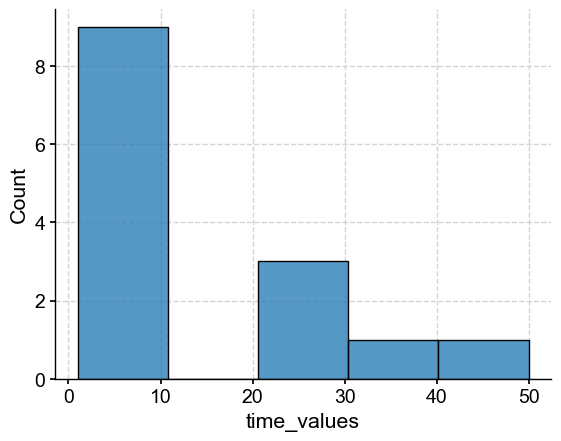

In [8]:
res_med = dfs_pre1600['time_values'].apply(lambda x: np.median(np.abs(np.diff(x)))) # looking at median spacing between time points for each record
sns.histplot(res_med)

Because PCA requires a common time grid, we have to be a little careful about the resolution of the records. Let's select those with a resolution finer than 20 years:

In [9]:
idx = np.where(res_med <= 20)
dfs_res = dfs_pre1600.loc[dfs_pre1600.index[idx]]
dfs_res.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 5 to 24
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             9 non-null      object 
 1   archiveType             9 non-null      object 
 2   geo_meanLat             9 non-null      float64
 3   geo_meanLon             9 non-null      float64
 4   geo_meanElev            9 non-null      float64
 5   paleoData_variableName  9 non-null      object 
 6   paleoData_values        9 non-null      object 
 7   paleoData_units         7 non-null      object 
 8   paleoData_proxy         9 non-null      object 
 9   paleoData_proxyGeneral  0 non-null      object 
 10  time_variableName       9 non-null      object 
 11  time_values             9 non-null      object 
 12  time_units              9 non-null      object 
 13  depth_variableName      0 non-null      object 
 14  depth_values            0 non-null      object 
 1

Now were are down to 9 proxy records. Next, we iterate over the rows of this dataframe, create GeoSeries objects for each proxy record, and bundle them all into a MultipleGeoSeries object (it will become obvious why in a second):

In [10]:
ts_list = []
for _, row in dfs_res.iterrows():
    ts_list.append(pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                                   time_name=row['time_variableName'],value_name=row['paleoData_variableName'],
                                   time_unit=row['time_units'], value_unit=row['paleoData_units'],
                                   lat = row['geo_meanLat'], lon = row['geo_meanLon'],
                                   elevation = row['geo_meanElev'], observationType = row['paleoData_proxy'],
                                   archiveType = row['archiveType'], verbose = False, 
                                   label=row['dataSetName']+'_'+row['paleoData_variableName'])) 

Euro2k = pyleo.MultipleGeoSeries(ts_list, label='Euro2k', time_unit='year AD')  

Once in this form, it's trivial to map these records all at once:

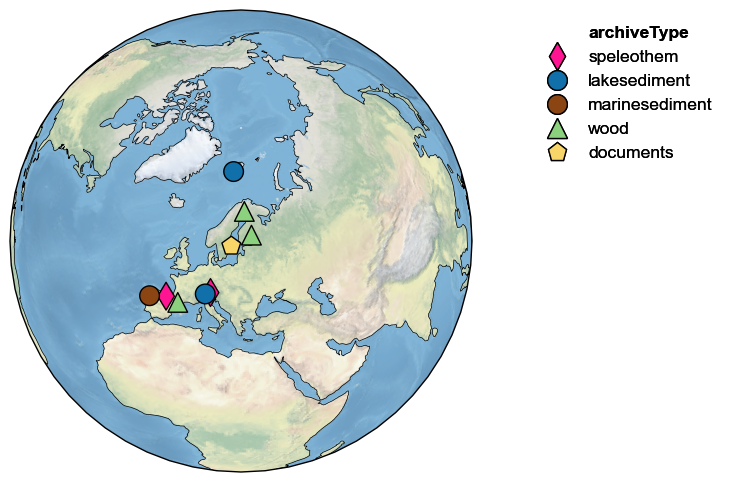

In [11]:
fig, ax = Euro2k.map()

For a relatively localized dataset like this, the default projection is "Orthographic" because it minimally distorts the represented surface, and reminds us that the Earth is (nearly) round (unlike some other, unnamed projections). For a full list of allowable projections, see the [cartopy documentation](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html). For more on this, see the [mapping notebook](). 

Because it may be relevant to interpreting the results, let's map elevation:

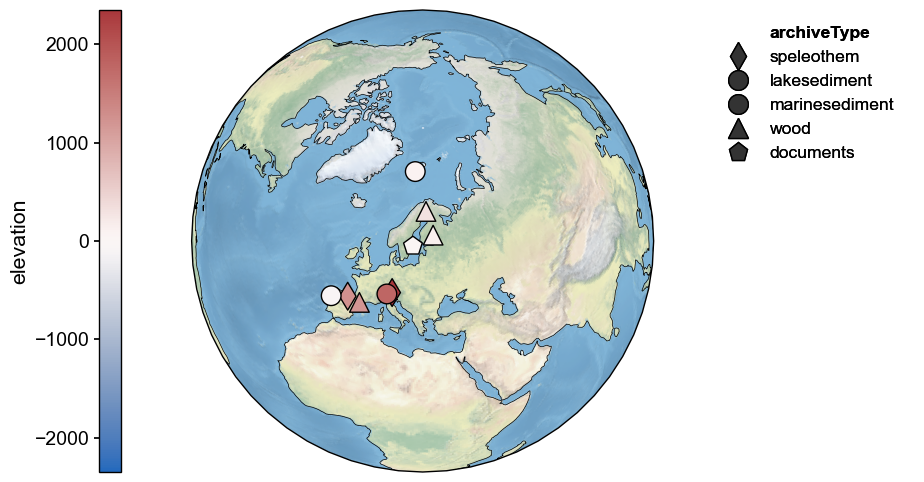

In [12]:
fig, ax = Euro2k.map(hue='elevation')

Most records are near sea level, though a few in the Pyrenees and Alps are at altitudes ov several thousand meters. It critical to look at the records themselves prior to feeding them to PCA:

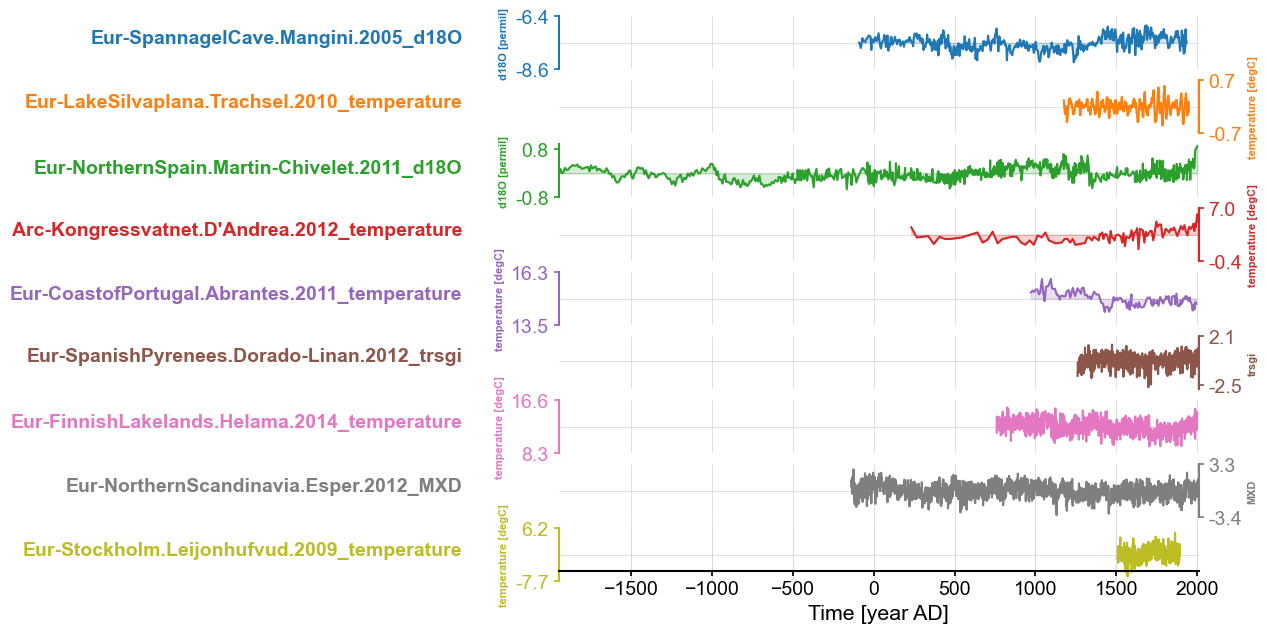

In [13]:
fig, ax = Euro2k.stackplot(v_shift_factor=1.2)

No red flags ; we are ready to proceed with PCA. Notice here that `Euro2k`, being an instance of `MultipleGeoSeries`, has access to all the methods of its parent class `MultipleSeries`, including `stackplot()`

### Principal Component Analysis

Now let's perform PCA. To do this, all the Series objects within the collection must be on a common time axis, and it's also prudent to standardize them so differences in units don't mess up the scaling of the data matrix on which PCA operates. We can perform both operations at once using method-chaining:

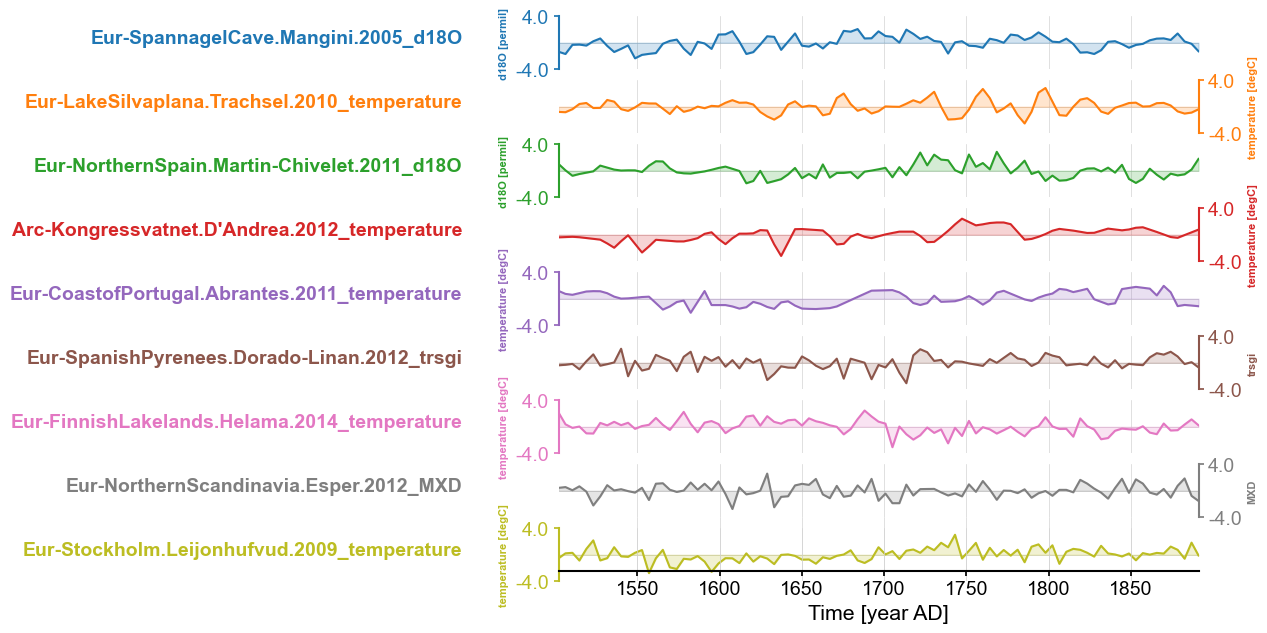

In [14]:
Euro2kc = Euro2k.common_time().standardize()
fig, ax = Euro2kc.stackplot(v_shift_factor=1.2)

The PCA part is extremely anticlimatic:

In [15]:
pca = Euro2kc.pca()
type(pca)

pyleoclim.core.multivardecomp.MultivariateDecomp

We placed the result of the operation into an object called "pca" (we felt very inspired when we wrote this), which is of type [MultivariateDecomp](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multivardecomp-pyleoclim-multivariatedecomp), which contains the following information:  

In [16]:
pca.__dict__.keys()

dict_keys(['name', 'eigvals', 'eigvecs', 'pctvar', 'pcs', 'neff', 'orig'])

- _name_ is a string used to label plots
- _eigvals_ is an array containing the eigenvalues of the covariance matrix
- _pctvar_ is the % of the total variance accounted for by each mode (derived from the eigenvalues)
- _eigvecs_ is an array containing the eigenvectors of the covariance matrix ()
- _pcs_ is an array containing the temporal  loadings corresponding to these eigenvectors.
- _neff_ is an estimate of the effective sample size ("degrees of freedom") associated with the principal component. Because of autocorrelation, this number is usually much smaller than the length of the timeseries itself. 
- _orig_ is the original MultipleGeoSeries (or MultipleSeries) object on which the multivariate decomposition was applied.
- _locs_ is an array containing the geographic coordinates as (lat, lon). 

The first thing one should look at in such an object is the eigenvalue spectrum, often called a [scree plot](https://en.wikipedia.org/wiki/Scree_plot):

The provided eigenvalue array has only one dimension. UQ defaults to NB82


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Euro2k PCA eigenvalues'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

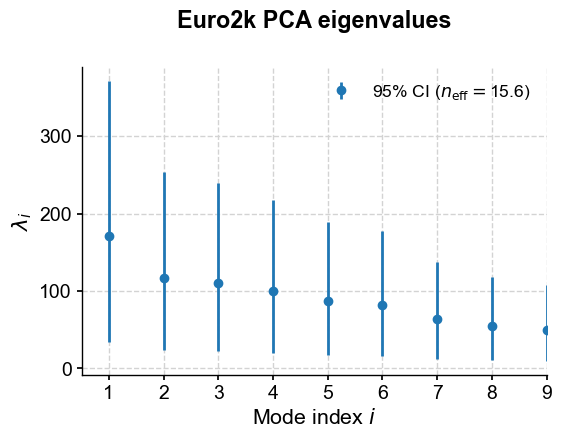

In [17]:
pca.screeplot()

As is nearly always the case with geophysical timeseries, the first handful of eigenvalues truly overwhelm the rest. Eigenvalues are, by themselves, not all that informative; their meaning comes from the fact that their normalized value quantifies the fraction of variance accounted for by each mode. That is readily accessed via:

In [18]:
pca.pctvar[:5] # display only the first 5 values, for brevity

array([20.49343085, 14.00994016, 13.22588398, 11.98053572, 10.41256573])

The first mode accounts for about 20% of the total variance; let's look at it via `modeplot()`

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year AD]', ylabel='$PC_1$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

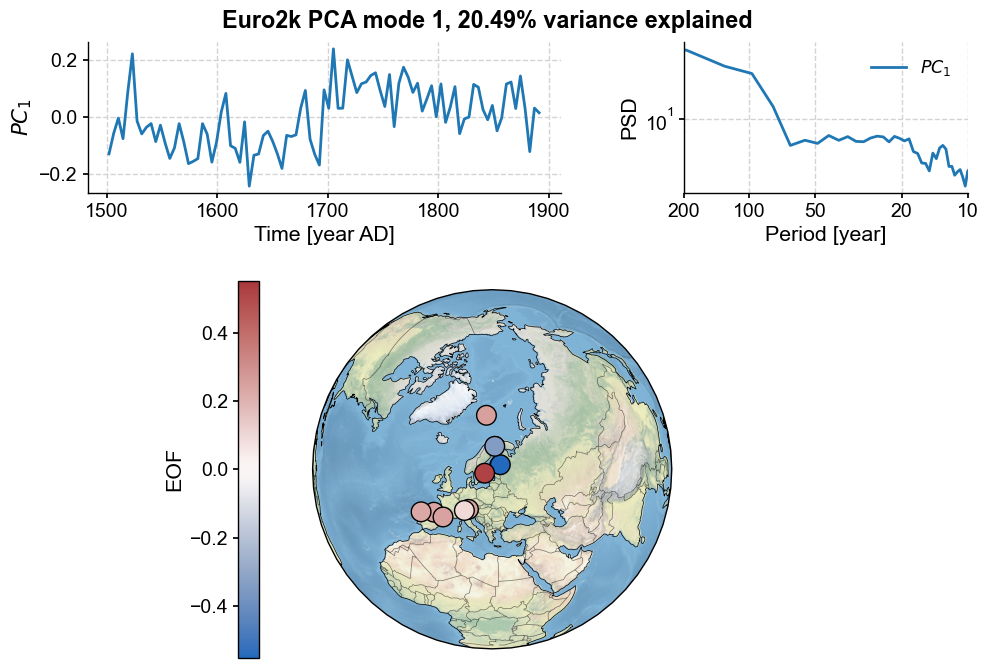

In [19]:
pca.modeplot()

Three features jump at us:
- firstly, the first principal component displays a sharp transition around the year 1675.
- the figure includes the PC's spectrum (here, using the MTM method), which is dominated by variation around 200 yr periods, corresponding to the shift in the middle of the series. 
- the default map projection is again orthographic, but can be adjusted. For instance, let's set a stereographic projection with bounds appropriate for Europe. Let's also adjust the size of the markers:

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year AD]', ylabel='$PC_1$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

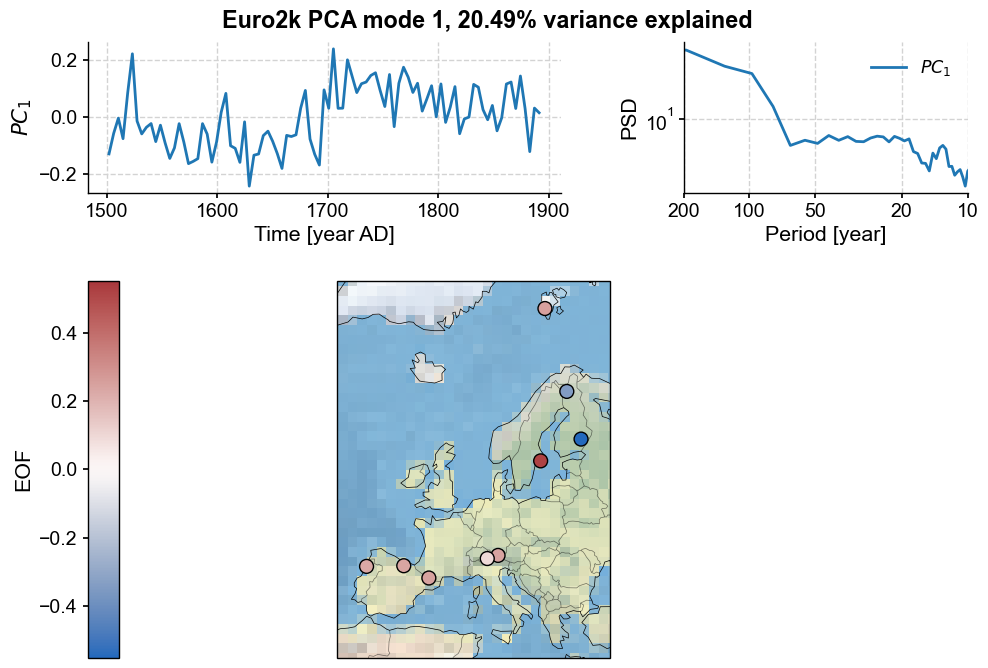

In [21]:
europe = [-10, 30,35,80]
pca.modeplot(map_kwargs={'projection':'Stereographic','extent':europe}, scatter_kwargs={'s':100})

 Now let's look at the second mode:

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year AD]', ylabel='$PC_2$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

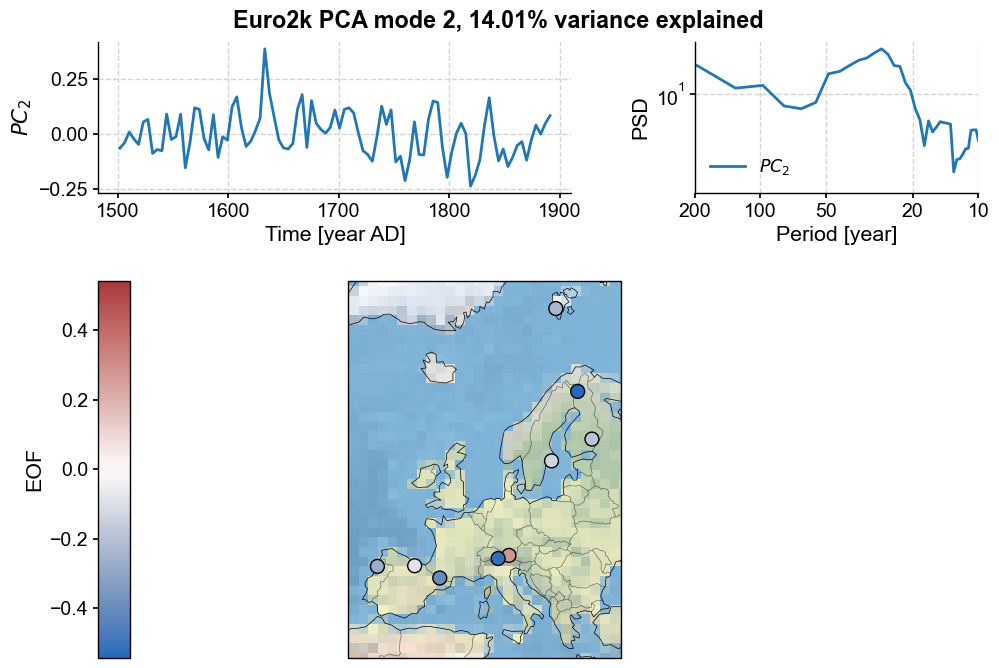

In [23]:
pca.modeplot(index=1, map_kwargs={'projection':'Stereographic','extent':europe}, scatter_kwargs={'s':100})

This one has a more uniforml spatial structure (loadings of one sign, withe one exception). This PC's spectrum shows energetic variability at multidecadal timescales. On to the third mode:

(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year AD]', ylabel='$PC_3$'>,
  'psd': <Axes: xlabel='Period [year]', ylabel='PSD'>,
  'map': {'cb': <Axes: ylabel='EOF'>,
   'map': <GeoAxes: xlabel='lon', ylabel='lat'>}})

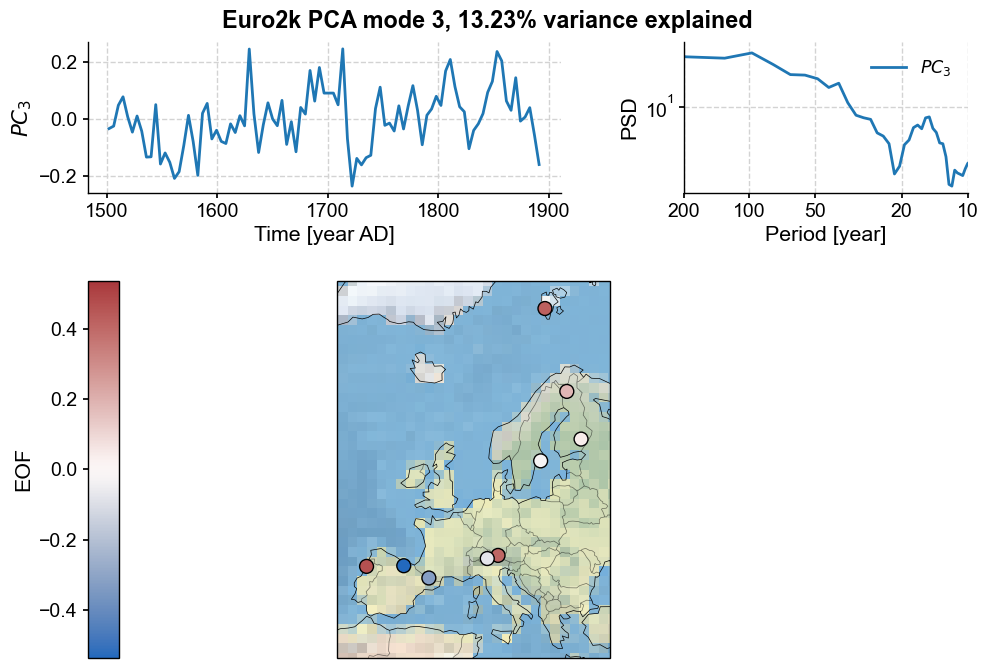

In [24]:
pca.modeplot(index=2, map_kwargs={'projection':'Stereographic','extent':europe}, scatter_kwargs={'s':100})

This PC shows evidence of scaling behavior, as well as decadal variability. To look at this in more detail, you could place the principal component into a `Series` object and apply the tools of [spectral analysis](L2_spectral_analysis.md):

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years]', ylabel='PSD'>)

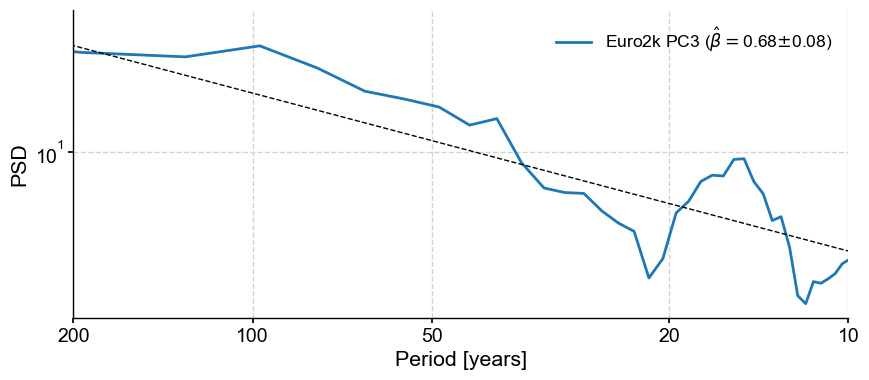

In [22]:
pc2 = pyleo.Series(value=pca.pcs[:,2], verbose=False, label='Euro2k PC3',
                   time = Euro2kc.series_list[0].time) # remember Python's zero-based indexing
pc2spec = pc2.spectral(method='mtm')                
pc2spec.beta_est().plot()

Indeed, the spectrum seems compatible with a shape $S(f) \propto f^{-\beta}$, where $\beta \approx 0.68$.

As usual with PCA, we could go down the list, but the interpretability becomes increasingly difficult. You have enough information to proceed with your own analysis now.

### Monte Carlo PCA

When age ensembles are available, we can use Monte Carlo PCA (MC-PCA) to robustly account for age uncertainty in such analyses.

PAGES 2k does not come with age ensembles, so for this example generate our own using the `Pyleoclim` method [random_time_axis()](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsmodel.random_time_axis). To emulate real proxies, we assign no age uncertainty to documentary records, minimal age uncertainties to tree-ring records, and larger age uncertainties to sedimentary records. Note that this is a very crude approximation of real processes, used here merely for illustration purposes. A research-grade assessment of age uncertainties should proceed much more carefully. All we need here is to generate reasonable ensembles so we can show how to analyze and visualize them.


In [23]:
mul_ens_list = []
num = 1000

for series in Euro2k.series_list:
    ens_list = []
    #Speleothems and wood are typically pretty well dated, though they should have some age errors
    if series.archiveType in ['Speleothem']:
        for idx in range(num):
            series_copy = series.copy()
            pert = pyleo.utils.tsmodel.random_time_axis(len(series_copy.time),
                                         delta_t_dist='random_choice',
                                         param =[[-3,-1,0,1,3],[0.02,0.04,0.88,0.04,0.02]])
            series_copy.time += pert
            ens_list.append(series_copy)
        ens = pyleo.EnsembleGeoSeries(ens_list,lat=series.lat,lon=series.lon,elevation=series.elevation,archiveType=series.archiveType)
    elif series.archiveType in ['Wood']:
        for idx in range(num):
            series_copy = series.copy()
            pert = pyleo.utils.tsmodel.random_time_axis(len(series_copy.time),
                                         delta_t_dist='random_choice',
                                         param =[[-.5,-.2,0,.2,.5],[0.02,0.04,0.88,0.04,0.02]])
            series_copy.time += pert
            ens_list.append(series_copy)
        ens = pyleo.EnsembleGeoSeries(ens_list,lat=series.lat,lon=series.lon,elevation=series.elevation,archiveType=series.archiveType)
    #Sediments should be a bit more smoothed when it comes to age errors
    elif series.archiveType in ['Lake sediment']:
        for idx in range(num):
            series_copy = series.copy()
            pert = pyleo.utils.tsmodel.random_time_axis(len(series_copy.time),
                                         delta_t_dist='random_choice',
                                         param =[[-2,-.5,0,.5,2],[0.02,0.04,0.88,0.04,0.02]])
            series_copy.time += pert
            ens_list.append(series_copy)
        ens = pyleo.EnsembleGeoSeries(ens_list,lat=series.lat,lon=series.lon,elevation=series.elevation,archiveType=series.archiveType)
    elif series.archiveType in ['Marine sediment']:
        for idx in range(num):
            series_copy = series.copy()
            pert = pyleo.utils.tsmodel.random_time_axis(len(series_copy.time),
                                         delta_t_dist='random_choice',
                                         param =[[-4,-2,0,2,4],[0.02,0.04,0.88,0.04,0.02]])
            series_copy.time += pert
            ens_list.append(series_copy)
        ens = pyleo.EnsembleGeoSeries(ens_list,lat=series.lat,lon=series.lon,elevation=series.elevation,archiveType=series.archiveType)
    #Documents should have zero age errors
    elif series.archiveType in ['Documents']:
        for idx in range(num):
            ens_list.append(series)
        ens = pyleo.EnsembleGeoSeries(ens_list,lat=series.lat,lon=series.lon,elevation=series.elevation,archiveType=series.archiveType)

    mul_ens_list.append(ens)

megs = pyleo.MulEnsGeoSeries(mul_ens_list)

We can take a look at our creation using the `stackplot()` method

(<Figure size 1000x1000 with 10 Axes>,
 {0: <Axes: ylabel='d18O [permil]'>,
  1: <Axes: ylabel='temperature [degC]'>,
  2: <Axes: ylabel='d18O [permil]'>,
  3: <Axes: ylabel='temperature [degC]'>,
  4: <Axes: ylabel='temperature [degC]'>,
  5: <Axes: ylabel='trsgi'>,
  6: <Axes: ylabel='temperature [degC]'>,
  7: <Axes: ylabel='MXD'>,
  8: <Axes: ylabel='temperature [degC]'>,
  'x_axis': <Axes: xlabel='Time [year AD]'>})

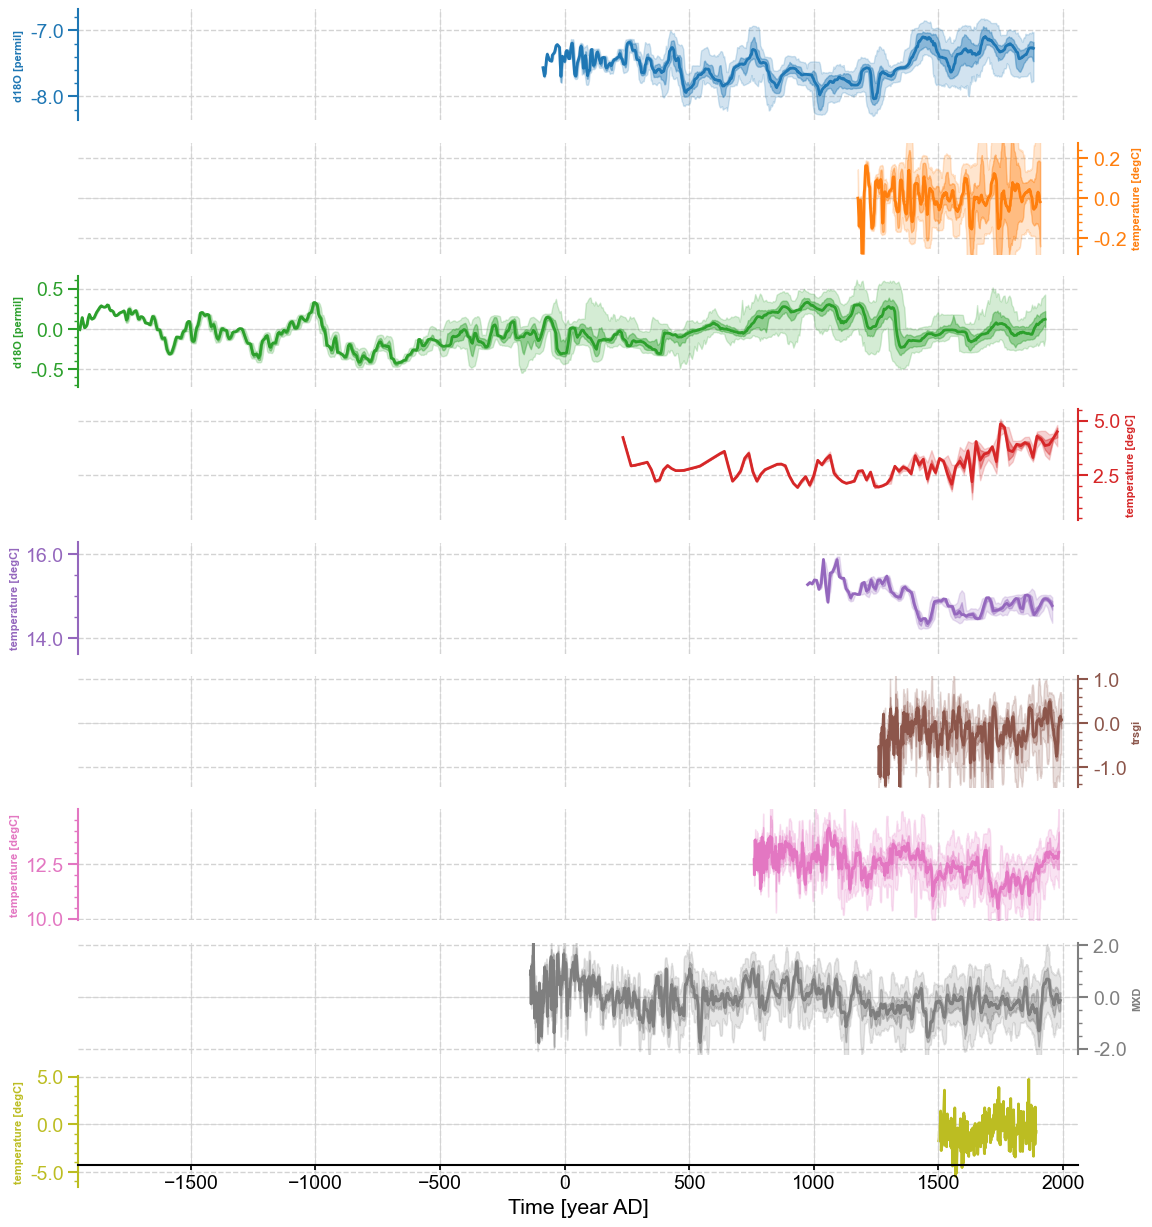

In [24]:
megs.stackplot(figsize=(10,10),plot_style='envelope',ylims='spacious',
               v_shift_factor=1.2, yticks_minor =True)

Once we've created these ensembles, appying MC-PCA is a breeze (and again is fairly anticlimatic)

In [25]:
mcpca = megs.mcpca()
type(mcpca)

Iterating over simulations: 100%|██████████| 1000/1000 [00:34<00:00, 29.12it/s]


pyleoclim.core.ensmultivardecomp.EnsMultivarDecomp

The contents of the `EnsMultivarDecomp` object are just a list of many PCA objects, with an optional label tag:

In [26]:
mcpca.__dict__.keys()

dict_keys(['pca_list', 'label'])

We can again produce a screeplot, which takes the form of a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) since each eigenvalue $\lambda_i$ contains 1,000 entries from the Monte Carlo simulations:

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Screeplot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

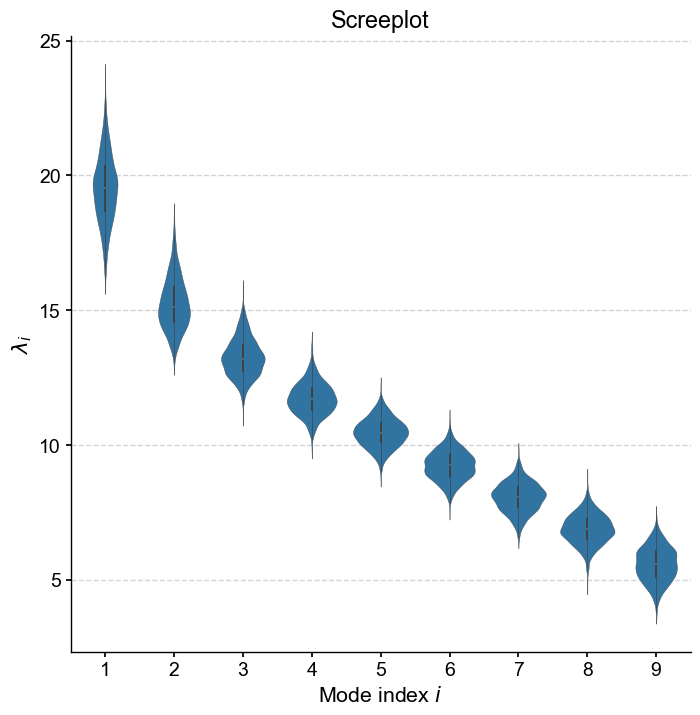

In [27]:
mcpca.screeplot()

[`modeplot()`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.ensmultivardecomp.EnsMultivarDecomp.modeplot) works similarly as in the non-ensemble case, but now the trace and spectra both showcase various essential quantiles:

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 563.19it/s]


(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year AD]', ylabel='$PC_1$'>,
  'psd': <Axes: xlabel='Period [year AD]', ylabel='PSD'>,
  'map': {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >}})

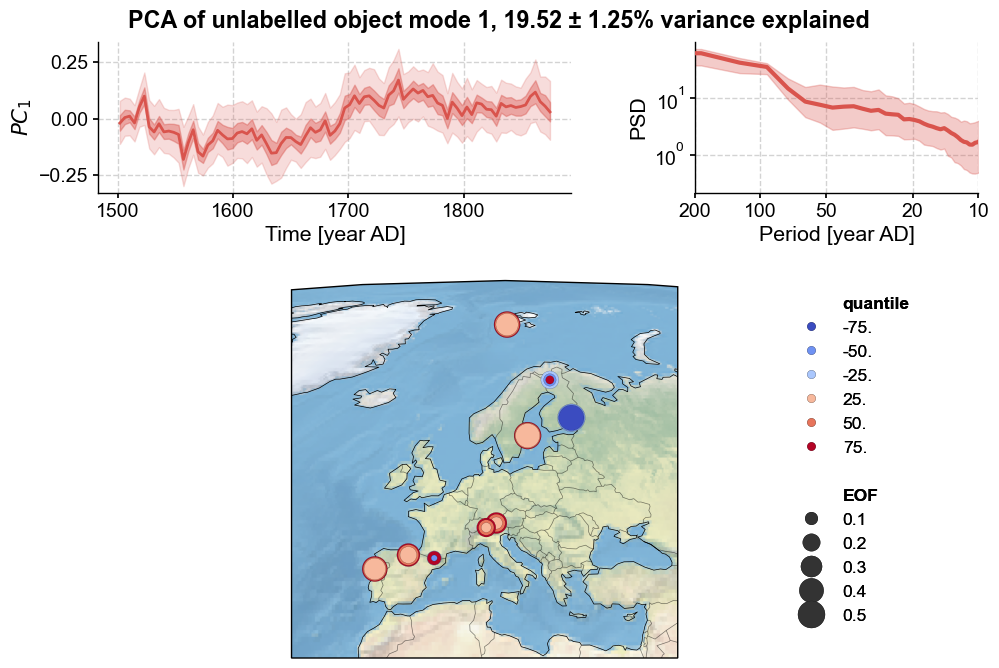

In [28]:
# Modeplot with some extra quality of life kwargs

mcpca.modeplot(
    index=0,
    scatter_kwargs={'sizes':(20,400),'linewidth':.1},
    map_kwargs={'projection':'Mollweide','extent':[-20,40,30,90]}
)

Modeplot produces a three-panel figure visualizing Monte Carlo Principal Component Analysis (MC-PCA) results for the selected PC (indicated via the index argument):

1. Top left: Selected PC time series with uncertainty shading.
2. Top right: Power spectral density of the selected PC.
3. Bottom: Global map of EOF loadings for the selected PC.

The map represents sites as colored dots, where colors indicate quantiles of EOF loading distributions across Monte Carlo iterations. For example, the 25th quantile represents the EOF value below which 25% of possible EOF values fall. Lighter shades denote lower quantiles, darker shades higher quantiles. The sign of the quantile indicates loading direction, and is associated with color. Blue signifies negative loadings, red positive. Dot size corresponds to loading magnitude. The representation of the spatial loadings is based on the convention of [Tierney et al (2013)](https://www.doi.org/10.1038/nature11785).  Concentric circles with different diameters are characteristic of large uncertainties; conversely, cases with circles of similar diameter indicate consistent loadings across the age ensemble.

Qualitatively the result is quite similar to the non-ensemble PCA case, although the transition around 1700 C.E. is smoother. This is perhaps in line with expectations, as the inclusion of age uncertainty will spread the timing of abrupt transitions slightly. 

Most records show uniformly strong loadings associated with this first mode, as indicated by the large, solid circles. The Easternmost record shows an opposite loading to the rest, indicating a potential spatial anticorrelation. Two records, namely the wood archives from Southern France and Finland, show heterogeneity in their loading directions (indicated by the superposition of warm and cool toned circles), suggesting a result that is not robust across their respective age models. 

However, we note that the age ensembles we created for this example are entirely artificial, so this result won't bear a great deal of scrutiny.

To look at higher modes:

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:01<00:00, 558.66it/s]


(<Figure size 800x800 with 4 Axes>,
 {'pc': <Axes: xlabel='Time [year AD]', ylabel='$PC_2$'>,
  'psd': <Axes: xlabel='Period [year AD]', ylabel='PSD'>,
  'map': {'map': <GeoAxes: xlabel='lon', ylabel='lat'>, 'leg': <Axes: >}})

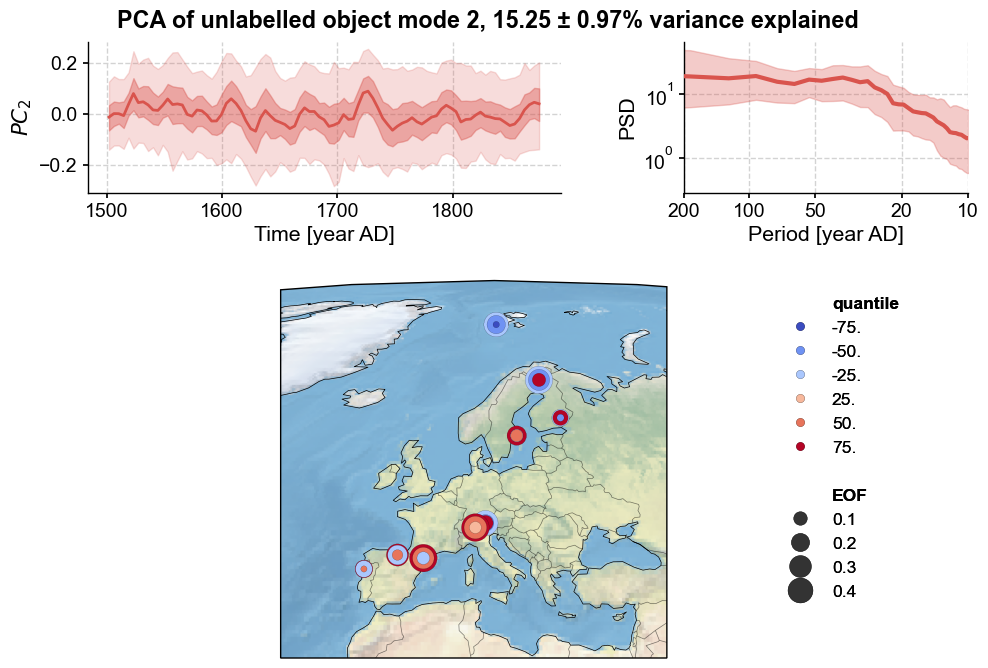

In [29]:
mcpca.modeplot(
    index=1,
    scatter_kwargs={'sizes':(20,400),'linewidth':.1},
    map_kwargs={'projection':'Mollweide','extent':[-20,40,30,90]}
)

This looks a lot like noise, as almost all of the records show heterogeneous loadings, and probably shouldn't be interpreted too deeply. 

One issue that you may run into using MC-PCA is a misalignment of PCs. Because the sign of PCs is arbitrary, there is no guarantee that different Monte Carlo simulations will have properly aligned PCs (the sign can flip on a dime). Some work is done behind the scenes to minimize this issue (note the `alignment_method` argument available when applying `mcpca()`), however for the lower variance modes, such techniques can only go so far in properly aligning the PCs. That is to say, great caution should be exercised when interpreting MC-PCA modes that account for lower percentages of the total variance.

### Conclusion

- PCA can be applied to both `MultipleGeoSeries` and `MulEnsembleGeoSeries` objects
- The latter are appropriate when age ensembles are available ("MC-PCA"). 
- In `Pyleoclim`, both methods have customizable plotting functions, allowing to visualize results in an intuitive way. 

If you have suggestions for additional features or domains of application, feel free to discuss them on our [discourse forum](https://discourse.linked.earth) or to open an [issue on GitHub](https://github.com/LinkedEarth/Pyleoclim_util/issues).

In [30]:
%watermark -n -u -v -iv -w

Last updated: Tue Jul 16 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

seaborn  : 0.13.2
pyleoclim: 1.0.0b0
numpy    : 1.26.4

Watermark: 2.4.3

